In [4]:
from google.colab import files
uploaded = files.upload()



Saving movies.csv to movies.csv


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('movies.csv')


In [6]:
df['ReleaseDate'] = pd.to_datetime(df['ReleaseDate'])


In [7]:
df['Profit'] = df['Revenue'] - df['Budget']


In [8]:
def get_era(date):
    if date.year < 2000:
        return 'Classic'
    elif 2000 <= date.year <= 2010:
        return 'Mid'
    else:
        return 'Modern'

df['Era'] = df['ReleaseDate'].apply(get_era)


In [9]:
df['Revenue'].fillna(df['Revenue'].mean(), inplace=True)


/tmp/ipython-input-4036005715.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Revenue'].fillna(df['Revenue'].mean(), inplace=True)


In [10]:
df_sorted = df.sort_values(by='Rating', ascending=False)


In [11]:
grouped = df.groupby('Genre').agg({'Rating': 'mean', 'Revenue': 'sum'})
print(grouped)


         Rating       Revenue
Genre                        
Action     8.70  3.802359e+09
Drama      8.40  1.074251e+09
Romance    7.85  3.615310e+09
Sci-Fi     8.70  1.503004e+09


In [12]:
high_perf = df[(df['Rating'] >= 8.5) & (df['Profit'] > 500_000_000)]
print(high_perf[['Title', 'Rating', 'Profit']])


             Title  Rating       Profit
0        Inception     8.8  665532764.0
1  The Dark Knight     9.0  819558444.0
3     Interstellar     8.6  512471339.0


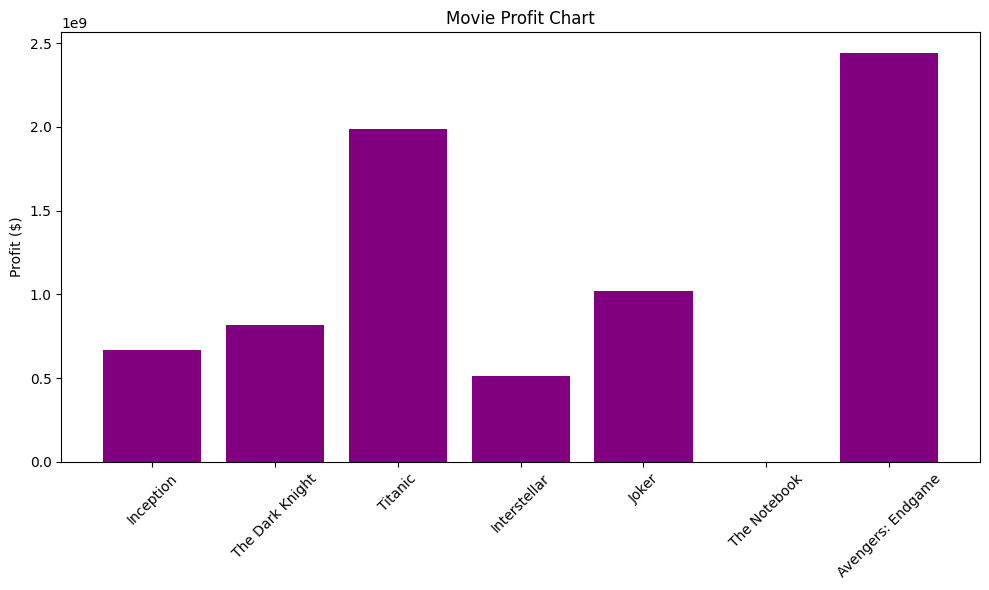

In [14]:
plt.figure(figsize=(10,6))
plt.bar(df['Title'], df['Profit'], color='purple')
plt.xticks(rotation=45)
plt.title("Movie Profit Chart")
plt.ylabel("Profit ($)")
plt.tight_layout()
plt.show()


 PART 2: PYSPARK OPERATIONS

In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, year, month, to_date, avg, sum as _sum, rank
from pyspark.sql.window import Window

spark = SparkSession.builder.appName("MovieAnalysis").getOrCreate()
df_spark = spark.read.csv("movies.csv", header=True, inferSchema=True)


In [16]:
df_spark = df_spark.withColumn("Profit", col("Revenue") - col("Budget"))


In [17]:
df_spark.filter((col("Genre") == "Sci-Fi") & (col("Profit") > 500_000_000)).show()


+-------+------------+------+-----------+------+---------+---------+---------+
|MovieID|       Title| Genre|ReleaseDate|Rating|  Revenue|   Budget|   Profit|
+-------+------------+------+-----------+------+---------+---------+---------+
|      1|   Inception|Sci-Fi| 2010-07-16|   8.8|825532764|160000000|665532764|
|      4|Interstellar|Sci-Fi| 2014-11-07|   8.6|677471339|165000000|512471339|
+-------+------------+------+-----------+------+---------+---------+---------+



In [18]:
df_spark.groupBy("Genre").agg(avg("Rating").alias("AvgRating"), _sum("Profit").alias("TotalProfit")).show()


+-------+---------+-----------+
|  Genre|AvgRating|TotalProfit|
+-------+---------+-----------+
|Romance|     7.85| 1987463944|
|  Drama|      8.4| 1019251311|
| Action|      8.7| 3261359008|
| Sci-Fi|      8.7| 1178004103|
+-------+---------+-----------+



In [19]:
df_spark = df_spark.withColumn("Category",
    when(col("Rating") == 9.0, "Blockbuster")
    .when((col("Rating") >= 8.0) & (col("Rating") < 9.0), "Hit")
    .otherwise("Average")
)


In [20]:
df_spark = df_spark.drop("Budget")


In [21]:
avg_revenue = df_spark.select(avg("Revenue")).first()[0]
df_spark = df_spark.na.fill({"Revenue": avg_revenue})


In [22]:
df_spark = df_spark.withColumn("ReleaseDate", to_date("ReleaseDate"))
df_spark = df_spark.withColumn("Year", year("ReleaseDate")).withColumn("Month", month("ReleaseDate"))


In [23]:
windowSpec = Window.partitionBy("Genre").orderBy(col("Profit").desc())
df_spark = df_spark.withColumn("RankInGenre", rank().over(windowSpec))
df_spark.select("Title", "Genre", "Profit", "RankInGenre").show()


+-----------------+-------+----------+-----------+
|            Title|  Genre|    Profit|RankInGenre|
+-----------------+-------+----------+-----------+
|Avengers: Endgame| Action|2441800564|          1|
|  The Dark Knight| Action| 819558444|          2|
|            Joker|  Drama|1019251311|          1|
|          Titanic|Romance|1987463944|          1|
|     The Notebook|Romance|      NULL|          2|
|        Inception| Sci-Fi| 665532764|          1|
|     Interstellar| Sci-Fi| 512471339|          2|
+-----------------+-------+----------+-----------+



 PART 3: JSON + UNION + ROI

In [26]:
import json

# Define the JSON data
bonus_data = [
    {
        "MovieID": 8,
        "Title": "Barbie",
        "Genre": "Drama",
        "Rating": 7.5,
        "Revenue": 1456000000,
        "Budget": 145000000
    },
    {
        "MovieID": 9,
        "Title": "Oppenheimer",
        "Genre": "Drama",
        "Rating": 8.6,
        "Revenue": 950000000,
        "Budget": 100000000
    }
]

with open('movies_bonus.json', 'w') as f:
    json.dump(bonus_data, f, indent=4)

In [27]:
bonus_df = spark.read.json("movies_bonus.json")


In [32]:
from pyspark.sql.functions import lit, to_date
bonus_df = bonus_df.withColumn("ReleaseDate", to_date(lit(None)))
df_combined = df_spark.unionByName(bonus_df, allowMissingColumns=True)



In [33]:
df_combined.orderBy(col("Revenue").desc()).select("Title", "Revenue").show(5)


+-----------------+----------+
|            Title|   Revenue|
+-----------------+----------+
|Avengers: Endgame|2797800564|
|          Titanic|2187463944|
|     The Notebook|1427846394|
|            Joker|1074251311|
|  The Dark Knight|1004558444|
+-----------------+----------+
only showing top 5 rows



In [ ]:
df_combined.write.csv("final_movies.csv", header=True, mode="overwrite")
